### RWSE-Checker: false-positives (false alarm) statistics from filtered corpus

In [1]:
from cassis import Cas, load_typesystem
from rwse import RWSE_Checker
from util.helper import collect_sentences_by_confusion_sets, normalize_report

import matplotlib.pyplot as plt
import numpy as np
import os
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` 

#### Read from corpus and collect sentences by confusion sets

In [3]:
with open('input/eng_news_2023_10K-sentences.txt', 'r') as f:
    sentences = f.readlines()

sentences_cleaned = [sentence.split('\t')[1].strip() for sentence in sentences]

nlp = spacy.load('en_core_web_sm')
sentences_by_confusion_sets = collect_sentences_by_confusion_sets(rwse.confusion_sets.values(), sentences_cleaned,nlp)

total = 0

for key, value in sorted(sentences_by_confusion_sets.items()):
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

before 13880
after 13344
Being,begin,being = 214
Capital,Capitol,capital = 50
Country,County,country,county = 135
Desert,desert,dessert = 7
Easy,ease,easy = 32
Effect,affect,effect = 31
Effects,affects,effects = 23
Except,accept,except = 21
Few,View,few,view = 108
Form,From,form,from = 861
Found,Fund,found,fund = 126
Fourth,forth,fourth = 36
Hole,Whole,hole,whole = 34
Lead,Led,lead,led = 95
Life,Live,life,live = 162
Mad,Made,mad,made = 155
Or,or,ore = 423
Past,passed,past = 81
Peace,Piece,peace,piece = 31
Plain,plain,plane = 12
Principal,principal,principle = 13
Provence,Province,province = 10
Quiet,Quite,quiet,quite = 37
Rise,raise,rise = 36
Safe,Save,safe,save = 50
Site,sight,site = 30
Split,spit,split = 9
Than,Then,than,then = 433
Their,There,They,their,there,they = 1530
Them,Theme,them,theme = 248
Things,things,thinks = 70
Three,Tree,three,tree = 181
To,Too,Two,to,too,two = 4444
Trail,Trial,trail,trial = 33
Weather,Whether,weather,whether = 66
Week,weak,week = 124
Were,Where,were,w

#### Determine RWSEs

In [4]:
T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

In [2]:
file_name = 'output/report_false_positives.csv'

result = dict()

if not os.path.exists(file_name):

    with open('output/false_positives.csv', 'w') as f:

        for confusion_set, sentences in sentences_by_confusion_sets.items():
            matches = 0
            rwse.set_confusion_sets([set(confusion_set.split(','))])
            for sentence in sentences:
                cas = Cas(ts)
                # TODO clean sentence?
                cas.sofa_string = sentence
                doc = nlp(cas.sofa_string)
                cas_sentence = S(begin=0, end=len(sentence))
                cas.add(cas_sentence)
                for token in doc:
                    cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                    cas.add(cas_token)
                rwse.check_cas(cas, ts)
                false_positives = cas.select(T_RWSE)
                if len(false_positives) != 0:
                    matches += 1
                    for item in false_positives:
                        before = cas.sofa_string[item.begin:item.end]
                        modified_string = cas.sofa_string[:item.begin] + ' [[' + cas.sofa_string[item.begin:item.end] + ']] ' +cas.sofa_string[item.end:]
                        print(f'{before} => {item.suggestion}' ,f'({item.certainty:.5f})' , modified_string, sep='\t', file=f)
            result[confusion_set] = {
                'num_sentences':len(sentences),
                'num_matches':matches,
            }
    with open(file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key, value in result.items():
            print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
else:
    with open(file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            print(confusion_set, num_matches, num_sentences, sep='\t', end='\n')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}

Except,accept,except	0	21
advice,advise	0	21
Effect,affect,effect	0	31
Being,begin,being	0	214
bitch,pitch	0	7
brakes,breaks	0	7
Capital,Capitol,capital	0	50
Site,sight,site	0	30
Country,County,country,county	3	135
crab,crap	0	2
Desert,desert,dessert	0	7
Easy,ease,easy	0	32
Effects,affects,effects	0	23
extend,extent	0	16
feat,feet	0	21
Few,View,few,view	0	108
Form,From,form,from	1	861
Fourth,forth,fourth	0	36
forms,forums	0	3
Found,Fund,found,fund	0	126
Lead,Led,lead,led	0	95
Life,Live,life,live	1	162
loose,lose	0	20
Mad,Made,mad,made	0	155
Or,or,ore	0	423
Past,passed,past	0	81
Peace,Piece,peace,piece	0	31
Plain,plain,plane	0	12
Principal,principal,principle	0	13
Provence,Province,province	0	10
Quiet,Quite,quiet,quite	0	37
Rise,raise,rise	0	36
Safe,Save,safe,save	0	50
Split,spit,split	0	9
Than,Then,than,then	0	433
Their,There,They,their,there,they	3	1530
Them,Theme,them,theme	1	248
Things,things,thinks	0	70
Trail,Trial,trail,trial	0	33
Three,Tree,three,tree	0	181
To,Too,Two,to,too,two	

#### Determine false-positive rate

In [7]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'false positive rate: {total_matches/total:.3f}')
print(f'falsely identified {total_matches} out of {total}')

false positive rate: 0.001
falsely identified 13 out of 13344


### Determine mean false-positive rate

In [3]:
file_name = 'output/report_false_positives.csv'

data_mean_fpr = normalize_report(file_name)

mean_fpr = sum(data_mean_fpr.values())/ len(data_mean_fpr)

print(f'Mean False-Positive-Rate = {mean_fpr:.10f}')

Mean False-Positive-Rate = 0.0013636069


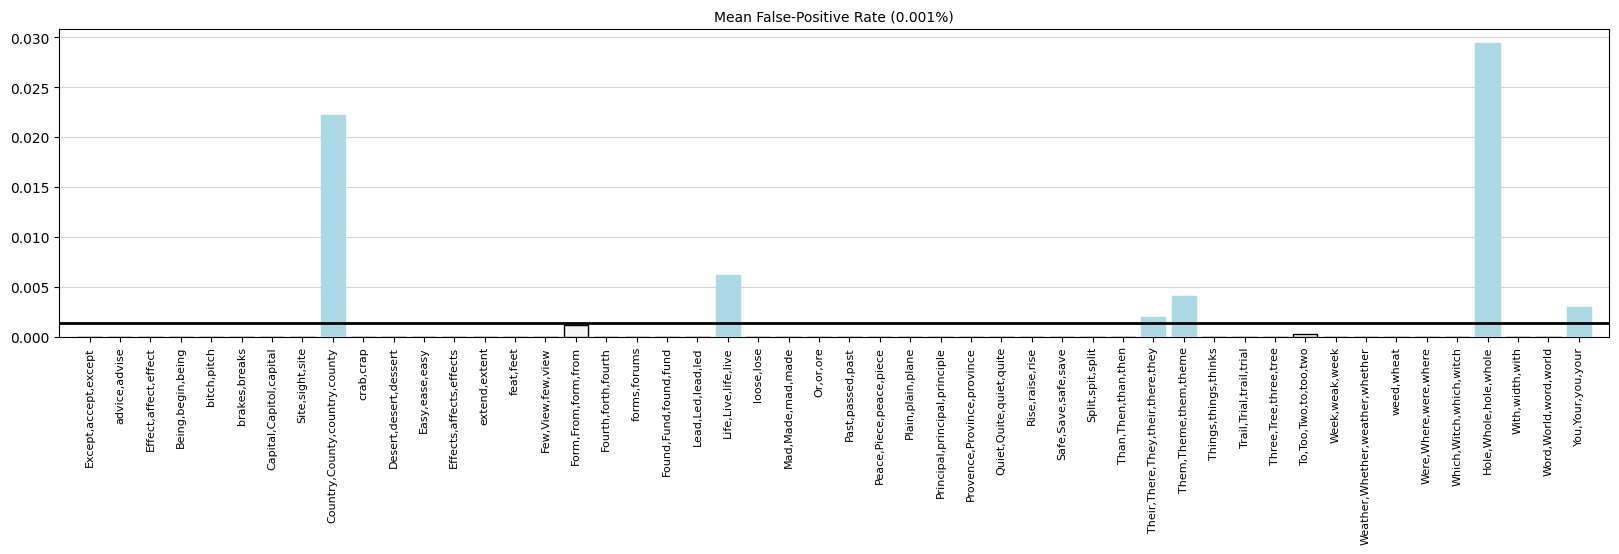

In [5]:
xticks = list(range(len(data_mean_fpr)))
values = list(data_mean_fpr.values())
labels = list(data_mean_fpr.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean False-Positive Rate ({mean_fpr:.3f}%)", fontsize=10)
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value > mean_fpr:
        bars[idx].set_color('lightblue')
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(x=0) # removes white space surrounding bars

x = np.linspace(-1, len(data_mean_fpr))
y = [mean_fpr]*len(x)
ax.plot(x, y, zorder=3, color="black", linewidth=2)

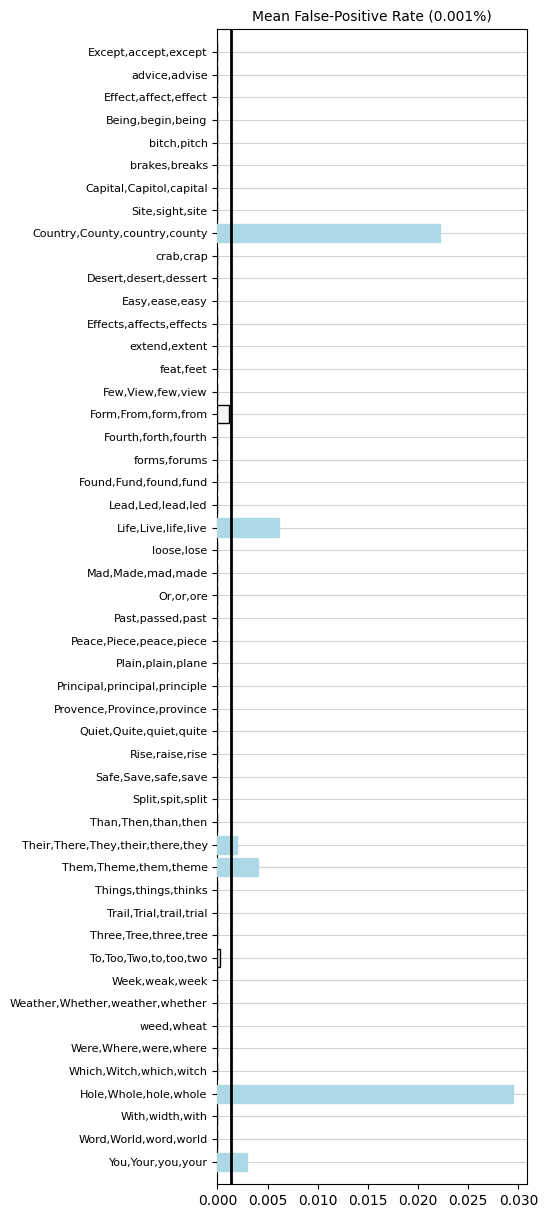

In [6]:
yticks = list(range(len(data_mean_fpr)))
values = list(data_mean_fpr.values())
labels = list(data_mean_fpr.keys())

values.reverse()
labels.reverse()

fig, ax = plt.subplots(figsize=(4,15))
ax.set_title(f"Mean False-Positive Rate ({mean_fpr:.3f}%)", fontsize=10)
bars = ax.barh(yticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value > mean_fpr:
        bars[idx].set_color('lightblue')
ax.set_yticks(yticks, labels, rotation='horizontal')
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(y=0)

x = [mean_fpr]*len(x)
y = np.linspace(-1, len(data_mean_fpr))
ax.plot(x, y, zorder=3, color="black", linewidth=2)